<a href="https://colab.research.google.com/github/aksy2512/Deep-Reinforcement-Learning---Policy-Gradient-Algorithms-and-DDPG/blob/main/Reinforce_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque

In [ ]:
# create the CartPole-v0 environment
env = gym.make('CartPole-v0')


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# define the policy network
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)
    

In [ ]:
# define the VPG algorithm
def reinforce(policy, policy_optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):    
    # Initialize lists for keeping track of episode scores and the last 100 scores
    scores_deque = deque(maxlen=100)
    scores = []
    # Loop over episodes
    policy_loss_ = [] # List to store the policy loss for each step in the episode
    for e in range(n_episodes):
        # Initialize lists for saving the log probabilities, rewards, and states for this episode
        saved_log_probs = []
        rewards = []
        states = []
        # Reset the environment and get the initial state
        env.reset()
        state = env.state
        

        # Loop over time steps within the episode
        for t in range(max_t):
            # Choose an action using the policy and save the log probability of that action
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            # Take a step in the environment with the chosen action, and save the resulting reward and next state
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            # If the episode is done (i.e. the cartpole has fallen over), exit the loop 
            if done:
                break
        
        # Calculate the total return for the episode, and create an array of returns with the same length as the rewards list            
        R_eps = sum(rewards)
        R = np.full(len(rewards), R_eps)
        scores.append(R[0])
        # Compute the policy loss for each time step in the episode
        for i, log_prob in enumerate(saved_log_probs):
            policy_loss_.append(-log_prob * R[i])
        # Calculate the total policy loss for the episode and backpropagate to update the policy weights 
    policy_loss = torch.cat(policy_loss_).sum()/1000  
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    

    return np.mean(scores)


iteration -  0


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


24.083
iteration -  1
26.201
iteration -  2
27.832
iteration -  3
30.076
iteration -  4
32.221
iteration -  5
35.298
iteration -  6
36.091
iteration -  7
39.609
iteration -  8
43.105
iteration -  9
44.689
iteration -  10
50.27
iteration -  11
52.047
iteration -  12
55.276
iteration -  13
59.591
iteration -  14
63.369
iteration -  15
68.841
iteration -  16
73.025
iteration -  17
81.781
iteration -  18
89.279
iteration -  19
100.955
iteration -  20
111.903
iteration -  21
119.42
iteration -  22
128.918
iteration -  23
136.764
iteration -  24
145.073
iteration -  25
151.546
iteration -  26
161.742
iteration -  27
169.037
iteration -  28
175.625
iteration -  29
181.519
iteration -  30
183.548
iteration -  31
185.023
iteration -  32
188.494
iteration -  33
189.122
iteration -  34
190.783
iteration -  35
194.881
iteration -  36
195.709
iteration -  37
196.376
iteration -  38
195.989
iteration -  39
196.221
iteration -  40
196.562
iteration -  41
197.427
iteration -  42
198.313
iteration -  4

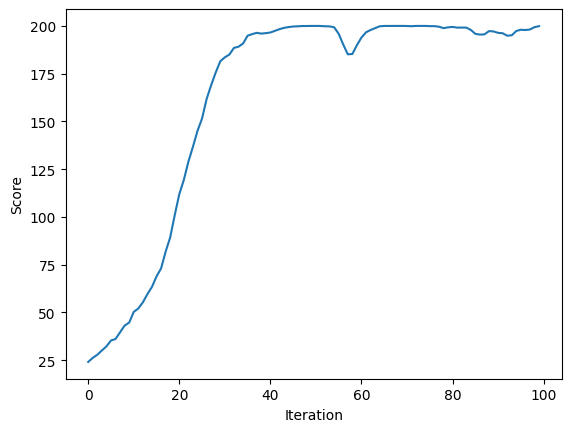

In [ ]:
# create the policy network and the optimizer
policy = Policy()
policy_optimizer = optim.Adam(policy.parameters(), lr=1e-2)

import matplotlib.pyplot as plt

# train the policy using VPG
scores = []
for itr in range(100):
    print("iteration - ",itr)
    score = reinforce(policy, policy_optimizer, n_episodes=1000, max_t = 500)
    print(score)

    scores.append(score)

# plot the learning curve
plt.plot(scores)
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.show()
    

In [ ]:
# define the Reinforce with Reward to Go
def reinforce_rew_to_go(policy, policy_optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):    
    # Initialize lists for keeping track of episode scores and the last 100 scores
    scores_deque = deque(maxlen=100)
    scores = []
    # Loop over episodes
    policy_loss_ = [] # List to store the policy loss for each step in the episode
    for e in range(n_episodes):
        # Initialize lists for saving the log probabilities, rewards, and states for this episode
        saved_log_probs = []
        rewards = []
        states = []
        # Reset the environment and get the initial state
        env.reset()
        state = env.state
        

        # Loop over time steps within the episode
        for t in range(max_t):
            # Choose an action using the policy and save the log probability of that action
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            # Take a step in the environment with the chosen action, and save the resulting reward and next state
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            # If the episode is done (i.e. the cartpole has fallen over), exit the loop 
            if done:
                break
          
        # Calculating Rewards for each time step in an episode
        R=[]
        curr_rew = 0
        n = len(rewards)
        for i in range(n):
            curr_rew = curr_rew*gamma + rewards[n-i-1]
            R.append(curr_rew)
        R.reverse()
        R = np.array(R)
        scores.append(R[0]) # Save the total return for the episode to the scores list
                       
        # Compute the policy loss for each time step in the episode
        for i, log_prob in enumerate(saved_log_probs):
            policy_loss_.append(-log_prob * R[i])
    # Calculate the total policy loss for the episode and backpropagate to update the policy weights 
    policy_loss = torch.cat(policy_loss_).sum()/1000 
    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    

    return np.mean(scores)

iteration -  0
19.759
iteration -  1
20.511
iteration -  2
20.869
iteration -  3
22.449
iteration -  4
22.492
iteration -  5
23.944
iteration -  6
25.76
iteration -  7
27.412
iteration -  8
28.852
iteration -  9
30.482
iteration -  10
31.379
iteration -  11
33.063
iteration -  12
34.804
iteration -  13
38.405
iteration -  14
39.297
iteration -  15
40.7
iteration -  16
45.124
iteration -  17
47.338
iteration -  18
50.399
iteration -  19
50.677
iteration -  20
54.407
iteration -  21
56.334
iteration -  22
58.913
iteration -  23
63.166
iteration -  24
64.518
iteration -  25
69.147
iteration -  26
70.991
iteration -  27
76.172
iteration -  28
83.055
iteration -  29
94.307
iteration -  30
103.031
iteration -  31
117.862
iteration -  32
135.724
iteration -  33
157.293
iteration -  34
165.392
iteration -  35
168.652
iteration -  36
174.63
iteration -  37
179.285
iteration -  38
184.894
iteration -  39
189.689
iteration -  40
193.327
iteration -  41
196.212
iteration -  42
197.337
iteration - 

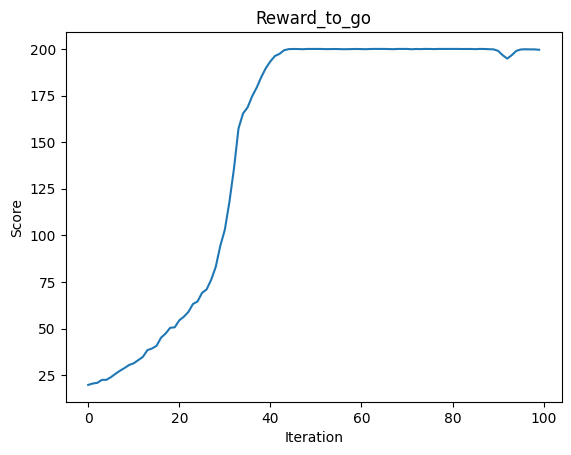

In [ ]:
# create the policy network and the optimizer
policy = Policy()
policy_optimizer = optim.Adam(policy.parameters(), lr=1e-2)

import matplotlib.pyplot as plt

# train the policy using VPG
scores = []
for itr in range(100):
    print("iteration - ",itr)
    score = reinforce_rew_to_go(policy, policy_optimizer, n_episodes=1000, max_t = 500)
    print(score)

    scores.append(score)

# plot the learning curve
plt.plot(scores)
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title("Reward_to_go")
plt.show()
    

In [ ]:

class ValueNet(torch.nn.Module):
  def __init__(self, state_size=4, hidden_layer_size=64):
    super(ValueNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_size, hidden_layer_size)
    self.fc2 = torch.nn.Linear(hidden_layer_size, 1)

  def forward(self, x):
    # x = torch.from_numpy(x).float()
    return self.fc2(torch.nn.functional.relu(self.fc1(x)))

In [ ]:
# define the Reinforce with Baseline 
def reinforce_baseline(policy, policy_optimizer, value_net, value_optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):    
    # Initialize lists for keeping track of episode scores and the last 100 scores
    scores_deque = deque(maxlen=100)
    scores = []
    policy_loss_ = [] # List to store the policy loss for each step in the episode
    value_loss_ = []  # List to store the value loss for each step in the episode
    # Loop over episodes
    for e in range(n_episodes):
        # Initialize lists for saving the log probabilities, rewards, and states for this episode
        saved_log_probs = []
        rewards = []
        states = []
        # Reset the environment and get the initial state
        env.reset()
        state = env.state
        


        # Loop over time steps within the episode
        for t in range(max_t):
            # Choose an action using the policy and save the log probability of that action
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            # Take a step in the environment with the chosen action, and save the resulting reward and next state
            state, reward, done, _ = env.step(action)
            # state = state.to(value.weight.dtype)
            rewards.append(reward)
            states.append(state)
            # If the episode is done (i.e. the cartpole has fallen over), exit the loop 
            if done:
                break
          
        # Calculating Rewards for each time step in an episode
        R=[]
        curr_rew = 0
        n = len(rewards)
        for i in range(n):
            curr_rew = curr_rew*gamma + rewards[n-i-1]
            R.append(curr_rew)
        R.reverse()
        R = np.array(R, dtype=np.float32)
        scores.append(R[0]) # Save the total return for the episode to the scores list

        # Compute the policy loss and the value loss for each time step in the episode
        for i, log_prob in enumerate(saved_log_probs):
            # Compute the value estimate for the current state
            state_tensor = torch.from_numpy(states[i]).float()
            state_value = value_net(state_tensor)
            
            # Compute the advantage for the current time step
            advantage = R[i] - state_value.item()
            
            # Compute the policy loss and append it to the policy loss list
            policy_loss_.append(-log_prob * advantage)
            
            # Compute the value loss and append it to the value loss list
            value_loss_.append(torch.nn.functional.mse_loss(state_value, torch.tensor([R[i]])))
                       
        # Calculate the total policy loss and the total value loss for the episode and backpropagate to update the policy and value weights
        
    policy_loss = torch.cat(policy_loss_).sum()/1000
    value_loss = torch.cat([v.unsqueeze(0) for v in value_loss_]).sum()/1000
    policy_optimizer.zero_grad()
    value_optimizer.zero_grad()
    policy_loss.backward()
    value_loss.backward()
    policy_optimizer.step()
    value_optimizer.step()
    

    return np.mean(scores)

iteration -  0
23.128
iteration -  1
24.57
iteration -  2
27.363
iteration -  3
29.409
iteration -  4
30.86
iteration -  5
32.912
iteration -  6
34.229
iteration -  7
35.838
iteration -  8
38.625
iteration -  9
41.644
iteration -  10
42.896
iteration -  11
46.712
iteration -  12
50.13
iteration -  13
51.841
iteration -  14
54.986
iteration -  15
57.407
iteration -  16
61.282
iteration -  17
63.215
iteration -  18
66.743
iteration -  19
72.259
iteration -  20
76.879
iteration -  21
80.842
iteration -  22
89.489
iteration -  23
97.498
iteration -  24
108.617
iteration -  25
122.972
iteration -  26
137.06
iteration -  27
154.718
iteration -  28
168.466
iteration -  29
177.816
iteration -  30
186.408
iteration -  31
189.104
iteration -  32
193.634
iteration -  33
196.097
iteration -  34
197.293
iteration -  35
198.78
iteration -  36
198.773
iteration -  37
198.46
iteration -  38
197.698
iteration -  39
197.445
iteration -  40
195.599
iteration -  41
190.484
iteration -  42
185.549
iteratio

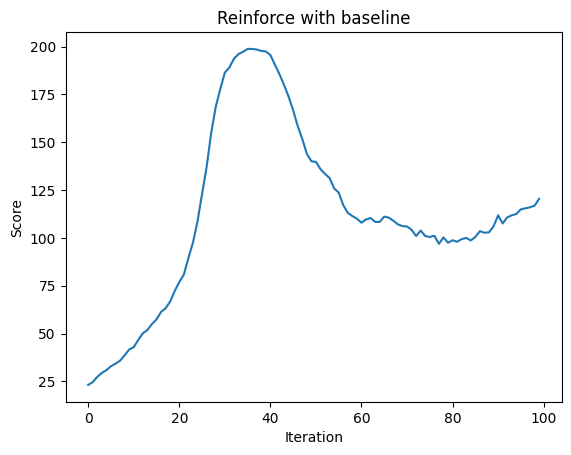

In [ ]:
# create the policy network and the optimizer
policy = Policy()

policy_optimizer = optim.Adam(policy.parameters(), lr=1e-2)

value = ValueNet()


value_optimizer = optim.Adam(value.parameters(),lr=1e-2)

import matplotlib.pyplot as plt

# train the policy using VPG
scores = []
for itr in range(100):
    print("iteration - ",itr)
    score = reinforce_baseline(policy, policy_optimizer,value, value_optimizer, n_episodes=1000, max_t = 500)
    print(score)

    scores.append(score)

# plot the learning curve
plt.plot(scores)
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title("Reinforce with baseline")
plt.show()
    

In [ ]:
class Actor(nn.Module):

    def __init__(self, state_dim, hidden_size, action_dim, max_action):
        super().__init__()
        self.state_dim = state_dim
        self.hidden_size = hidden_size
        self.action_dim = action_dim
        self.max_action = max_action
        self.seq = nn.Sequential(
            nn.Linear(self.state_dim, self.hidden_size),
            nn.ReLU(inplace=True),
#             nn.Linear(self.hidden_size, self.hidden_size),
#             nn.ReLU(inplace=True),
            nn.Linear(self.hidden_size, self.action_dim)
        )
        self.ac = nn.Sigmoid()
        for layer in self.seq:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(0, 0.01)
    
    def forward(self, state: torch.Tensor)->torch.Tensor:
        state = state.view(-1, self.state_dim)
        x = self.seq(state)
        x = self.max_action * self.ac(x)
        return x

class Critic(nn.Module):

    def __init__(self, state_dim, hidden_size, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.hidden_size = hidden_size
        self.action_dim = action_dim
        self.seq = nn.Sequential(
            nn.Linear(state_dim+action_dim, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size, 1)
        )
        for layer in self.seq:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(0, 0.01)
    
    def forward(self, state, action):
        state = state.view(-1, self.state_dim)
        action = action.view(-1, self.action_dim)
        x = torch.cat([state, action], dim=1)
        x = self.seq(x)
        return x


In [ ]:
import random
from collections import deque

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=buffer_size)

    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
    def remove(self,sz):
        for i in range(sz):
          self.buffer.pop()
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = random.sample(range(buffer_size), batch_size)
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in index:
            experience = self.buffer[i]
            state, action, reward, next_state, done = experience
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
        return states, actions, rewards, next_states, dones


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define DDPG agent
class DDPGAgent:

    def __init__(self, state_dim,action_dim, max_action,device):
        self.actor = Actor(state_dim, 128, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, 128, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        self.critic = Critic(state_dim, 128, action_dim).to(device)
        self.critic_target = Critic(state_dim, 128, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        self.replay_buffer = ReplayBuffer(10000)
        self.max_action = max_action
        self.device = device

    def select_action(self, state, noise=0.1):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        action = self.actor(state).cpu().data.numpy().flatten()
        action = (action + np.random.normal(0, noise, size=self.actor.action_dim))
        return np.clip(action, -self.max_action, self.max_action)

    

    def train(self, batch_size, gamma=0.99, tau=0.005):
      # Sample a minibatch from the replay buffer
      state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.replay_buffer.sample(batch_size)

      # Convert the numpy arrays to PyTorch tensors
      state_batch = torch.FloatTensor(state_batch).to(self.device)
      action_batch = torch.FloatTensor(action_batch).to(self.device)
      reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1).to(self.device)
      next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
      done_batch = torch.FloatTensor(done_batch).unsqueeze(1).to(self.device)

      # Compute the target Q-value using the target networks
      next_actions = self.actor_target(next_state_batch)
      target_Q = self.critic_target(next_state_batch, next_actions)
      target_Q = reward_batch + (1 - done_batch) * gamma * target_Q

      # Compute the current Q-value using the critic network
      current_Q = self.critic(state_batch, action_batch)

      # Compute the critic loss and update the critic network
      critic_loss = F.mse_loss(current_Q, target_Q.detach())
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()

      # Compute the actor loss and update the actor network
      pred_actions = self.actor(state_batch)
      actor_loss = -self.critic(state_batch, pred_actions).mean()
      self.actor_optimizer.zero_grad()
      actor_loss.backward()
      self.actor_optimizer.step()

      # Update the target networks by soft update
      for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

      for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

      return critic_loss.item(), actor_loss.item()

In [ ]:

# Initialize lists for keeping track of episode scores and the last 100 scores
def DDPG(n_episodes,max_t,batch_size,gamma,tau,noise_std,agent,device ):
  scores_deque = deque(maxlen=100)
  scores = []

  # Loop over episodes
  for e in range(n_episodes):
      # Reset the environment and get the initial state
      state = env.reset()
      score = 0
      
      # Loop over time steps within the episode
      for t in range(max_t):
          # Choose an action using the actor network and add some noise to the action
          action = agent.select_action(state, noise_std)
          if(action[0]>=0.5):
            action=1
          else: 
            action=0
          # Take a step in the environment with the chosen action, and save the resulting reward and next state
          
          next_state, reward, done, _ = env.step(action)
          # Add the experience to the agent's replay buffer
          agent.replay_buffer.add(state, action, reward, next_state, done)
          # Update the agent's networks if it's time to train
          # print(len(agent.replay_buffer))
          if len(agent.replay_buffer)%batch_size==0:

              # print(len(agent.replay_buffer))
              agent.train(batch_size, gamma, tau)
          # Update the current state and score
          state = next_state
          score += reward
          # If the episode is done (i.e. the cartpole has fallen over), exit the loop 
          if done:
              break
      if(len(agent.replay_buffer)==10000):
          agent.replay_buffer.remove(batch_size*2)
      if (e+1) % 100 == 0:
        print('Episode [{}/{}]\tAverage Score: {:.2f}'.format(e+1, n_episodes, np.mean(scores_deque)))
      # Append the score to the episode scores and the deque of the last 100 scores
      # agent.train(batch_size)
      scores.append(score)
      scores_deque.append(score)
  return np.mean(scores)    


In [ ]:
import matplotlib.pyplot as plt

# Set the device to use (GPU or CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the agent
agent = DDPGAgent(state_dim=4, action_dim=1, max_action=1.0, device=device)

# Define hyperparameters
n_episodes = 1000
max_t = 1000
batch_size = 64
gamma = 0.99
tau = 0.005
noise_std = 0.3

scores = []
for itr in range(100):
    print("iteration - ",itr)
    score = DDPG(n_episodes,max_t,batch_size,gamma,tau,noise_std,agent,device)
    print(score)

    scores.append(score)




iteration -  0
Episode [100/1000]	Average Score: 24.16
Episode [200/1000]	Average Score: 22.34
Episode [300/1000]	Average Score: 21.85
Episode [400/1000]	Average Score: 20.89
Episode [500/1000]	Average Score: 21.24
Episode [600/1000]	Average Score: 22.34
Episode [700/1000]	Average Score: 20.33
Episode [800/1000]	Average Score: 20.85
Episode [900/1000]	Average Score: 21.45
Episode [1000/1000]	Average Score: 20.38
21.571
iteration -  1
Episode [100/1000]	Average Score: 21.55
Episode [200/1000]	Average Score: 20.71
Episode [300/1000]	Average Score: 20.43
Episode [400/1000]	Average Score: 22.60
Episode [500/1000]	Average Score: 23.89
Episode [600/1000]	Average Score: 21.41
Episode [700/1000]	Average Score: 22.43
Episode [800/1000]	Average Score: 24.50
Episode [900/1000]	Average Score: 23.15
Episode [1000/1000]	Average Score: 24.29
22.491
iteration -  2
Episode [100/1000]	Average Score: 23.58
Episode [200/1000]	Average Score: 27.01
Episode [300/1000]	Average Score: 24.99
Episode [400/1000]	

In [ ]:
for itr in range(100):
    print("iteration - ",itr+101)
    score = DDPG(n_episodes,max_t,batch_size,gamma,tau,noise_std,agent,device)
    print(score)

    scores.append(score)

iteration -  101
Episode [100/1000]	Average Score: 50.31
Episode [200/1000]	Average Score: 51.74
Episode [300/1000]	Average Score: 52.04
Episode [400/1000]	Average Score: 49.78
Episode [500/1000]	Average Score: 54.31
Episode [600/1000]	Average Score: 57.36
Episode [700/1000]	Average Score: 59.19
Episode [800/1000]	Average Score: 60.93
Episode [900/1000]	Average Score: 60.80
Episode [1000/1000]	Average Score: 61.46
55.81
iteration -  102
Episode [100/1000]	Average Score: 63.62
Episode [200/1000]	Average Score: 66.80
Episode [300/1000]	Average Score: 66.43
Episode [400/1000]	Average Score: 69.43
Episode [500/1000]	Average Score: 70.21
Episode [600/1000]	Average Score: 71.36
Episode [700/1000]	Average Score: 75.16
Episode [800/1000]	Average Score: 76.00
Episode [900/1000]	Average Score: 78.11
Episode [1000/1000]	Average Score: 87.00
72.435
iteration -  103
Episode [100/1000]	Average Score: 90.09
Episode [200/1000]	Average Score: 95.39
Episode [300/1000]	Average Score: 102.81
Episode [400/

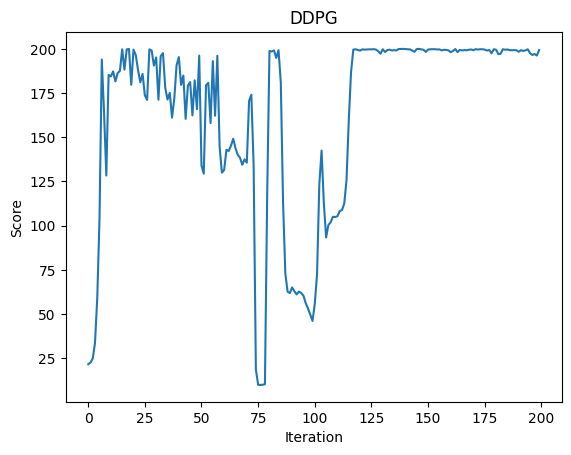

In [ ]:
# plot the learning curve
plt.plot(scores)
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.title("DDPG")
plt.show()